In [ ]:
"""
Example code of a simple RNN, GRU, LSTM on the MNIST dataset.

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-05-09 Initial coding
*    2022-12-16 Updated with more detailed comments, docstrings to functions, and checked code still functions as intended.

"""

# Imports
import numpy as np
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import datetime
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
    Dataset, 
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
input_size = 2
hidden_size = 256
num_layers = 2
num_classes = 10
sequence_length = 28
learning_rate = 0.005
batch_size = 1
num_epochs = 5

class CovidDataset(Dataset):
    def __init__(self, dates, hospitalizations, deaths):
        self.dates = dates
        self.hospitalizations = hospitalizations
        self.deaths = deaths

    def __getitem__(self, index):
        date = self.dates[index]
        hospitalization = self.hospitalizations[index]
        death = self.deaths[index]
        return date, hospitalization, death

    def __len__(self):
        return len(self.deaths)



# Recurrent neural network (many-to-one)
#class RNN(nn.Module):
#    def __init__(self, input_size, hidden_size, num_layers, num_classes):
#        super(RNN, self).__init__()
#        self.hidden_size = hidden_size
#        self.num_layers = num_layers
#        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
#
#    def forward(self, x):
#        # Set initial hidden and cell states
#        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#
#        # Forward propagate LSTM
#        out, _ = self.rnn(x, h0)
#        out = out.reshape(out.shape[0], -1)
#
#        # Decode the hidden state of the last time step
#        out = self.fc(out)
#        return out
#
#import torch
#import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Recurrent neural network with GRU (many-to-one)
#class RNN_GRU(nn.Module):
#    def __init__(self, input_size, hidden_size, num_layers, num_classes):
#        super(RNN_GRU, self).__init__()
#        self.hidden_size = hidden_size
#        self.num_layers = num_layers
#        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
#
#    def forward(self, x):
#        # Set initial hidden and cell states
#        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#
#        # Forward propagate LSTM
#        out, _ = self.gru(x, h0)
#        out = out.reshape(out.shape[0], -1)
#
#        # Decode the hidden state of the last time step
#        out = self.fc(out)
#        return out


# Recurrent neural network with LSTM (many-to-one)
#class RNN_LSTM(nn.Module):
#    def __init__(self, input_size, hidden_size, num_layers, num_classes):
#        super(RNN_LSTM, self).__init__()
#        self.hidden_size = hidden_size
#        self.num_layers = num_layers
#        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
#
#    def forward(self, x):
#        # Set initial hidden and cell states
#        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#
#        # Forward propagate LSTM
#        out, _ = self.lstm(
#            x, (h0, c0)
#        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
#        out = out.reshape(out.shape[0], -1)
#
#        # Decode the hidden state of the last time step
#        out = self.fc(out)
#        return out

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('us.csv', header=None)



# Extract the desired rows
# Step 1: Convert the dates, hospitalizations, and deaths into separate arrays
datesOG = np.array(df.iloc[:, 0])
hospitalizationsOG = np.array(df.iloc[:, 1])
deathsOG = np.array(df.iloc[:, 2])

# Integer encoding for dates
unique_dates = sorted(list(set(datesOG)))
date_to_int = {date: i for i, date in enumerate(unique_dates)}
train_dates = np.array([date_to_int[date] for date in datesOG])


# Load Data

train_dataset = np.column_stack((train_dates, hospitalizationsOG, deathsOG))

test_dataset = np.column_stack((train_dates, hospitalizationsOG, deathsOG))

covid_dataset = CovidDataset(train_dates, hospitalizationsOG, deathsOG)
train_loader = DataLoader(dataset=covid_dataset, batch_size=batch_size, shuffle=True)


test_loader = DataLoader(dataset=covid_dataset, batch_size=batch_size, shuffle=True)

# Initialize network (try out just using simple RNN, or GRU, and then compare with LSTM)
#model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (dates, hospitalizations, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        targets = targets.float()

        #targets = targets.long().clamp(0, num_classes - 1)

        #data = torch.stack((torch.tensor(dates), torch.tensor(hospitalizations)), dim=1)
        data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1)

        # forward
        scores = model(data.unsqueeze(0))
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for dates, hospitalizations, targets in loader:
            # Get data to cuda if possible
            targets = targets.long().clamp(0, num_classes - 1)
            data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1)

            # Forward pass
            scores = model(data.unsqueeze(0))
            _, predictions = scores.max(1)

            # Count correct predictions
            num_correct += (predictions == targets).sum().item()
            num_samples += predictions.size(0)

    # Toggle model back to train mode
    model.train()

    # Compute accuracy
    accuracy = num_correct / num_samples * 100
    return accuracy

train_accuracy = check_accuracy(train_loader, model)
test_accuracy = check_accuracy(test_loader, model)


print(f"Accuracy on training set: {train_accuracy:.2f}%")
print(f"Accuracy on test set: {test_accuracy:.2f}%")


In [ ]:
with torch.no_grad():
    for day in range(forecast_days):
        # Get the last 'sequence_length' days of the existing data for the input sequence
        last_sequence_data = input_sequences[-sequence_length:]

        # Prepare the input sequence for the next day
        next_input_sequence = get_next_input_sequence(last_sequence_data, sequence_length)

        # Move the input sequence to the same device as the model
        next_input_sequence = next_input_sequence.to(device)

        # Get the entity and relation embeddings for the next day (based on the first 100 data points)
        next_entity_embedding = entity_embeddings_tensor[day:day + len(input_sequences)].unsqueeze(0)
        next_relation_embedding = relation_embeddings_tensor[day:day + len(input_sequences)].unsqueeze(0)

        # Move the embeddings to the same device as the model
        next_entity_embedding = next_entity_embedding.to(device)
        next_relation_embedding = next_relation_embedding.to(device)

        # Generate the prediction for the next day
        prediction = model(next_input_sequence, next_entity_embedding, next_relation_embedding)

        # Convert the prediction tensor to a numpy array and denormalize it
        prediction_np = prediction.squeeze().cpu().numpy()
        denormalized_prediction = denormalize(prediction_np, np.mean(targets[:, 6]), np.std(targets[:, 6]))

        # Append the denormalized prediction to the estimations list
        estimations.append(denormalized_prediction)

        # Update the input_sequences with the new prediction for the next day
        input_sequences = torch.cat([input_sequences, next_input_sequence], dim=0)


In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for dates, hospitalizations, targets in loader:
            # Get data to cuda if possible
            targets = targets.long().clamp(0, num_classes - 1)
            data = torch.stack((torch.tensor(dates, dtype=torch.float32), torch.tensor(hospitalizations, dtype=torch.float32)), dim=1)

            # Forward pass
            _, predictions = scores.max(1)

            # Count correct predictions
            num_correct += (predictions == targets).sum().item()
            num_samples += predictions.size(0)

    # Toggle model back to train mode
    model.train()

    # Compute accuracy
    accuracy = num_correct / num_samples * 100
    return accuracy

train_accuracy = check_accuracy(train_loader, model)
test_accuracy = check_accuracy(test_loader, model)


print(f"Accuracy on training set: {train_accuracy:.2f}%")
print(f"Accuracy on test set: {test_accuracy:.2f}%")

In [ ]:
def predict_death(model, date, hospitalization):
    model.eval()

    date = torch.tensor([date_to_int[date]], dtype=torch.float32)
    hospitalization = torch.tensor([hospitalization], dtype=torch.float32)

    data = torch.stack((date, hospitalization), dim=1)
    with torch.no_grad():
        output = model(data.unsqueeze(0))
    
    print( output)

    model.train()

    return 0

# Example usage
user_date  = '2023-03-07'

user_hospitalization = 1129530

predicted_deaths = predict_death(model, user_date, user_hospitalization)
print(f"Predicted deaths on {user_date} with {user_hospitalization} hospitalizations: {predicted_deaths:.2f}")


## This is a new simple one

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

##3333333333333333333333333333333333333333333333333

df = pd.read_csv('us.csv', header=None)

# Extract the desired rows
datesOG = np.array(df.iloc[:, 0])
hospitalizations = np.array(df.iloc[:, 1])
deaths = np.array(df.iloc[:, 2])

## Normalize
hospitalizations_norm = (hospitalizationsOG - hospitalizationsOG.min()) / (
    hospitalizationsOG.max() - hospitalizationsOG.min()
)
deaths_norm = (deathsOG - deathsOG.min()) / (deathsOG.max() - deathsOG.min())
# Integer encoding for dates

unique_dates = sorted(list(set(datesOG)))
date_to_int = {date: i for i, date in enumerate(unique_dates)}
train_dates = np.array([date_to_int[date] for date in datesOG])

# Sample data
dates = train_dates



# Normalize the data
#dates_norm = (dates - np.mean(dates)) / np.std(dates)
hospitalizations_norm = (hospitalizations - np.mean(hospitalizations)) / np.std(hospitalizations)
deaths_norm = (deaths - np.mean(deaths)) / np.std(deaths)

# Convert data to PyTorch tensors
dates_tensor = torch.tensor(dates.reshape(-1, 1, 1), dtype=torch.float32)
hospitalizations_tensor = torch.tensor(hospitalizations_norm.reshape(-1, 1, 1), dtype=torch.float32)
deaths_tensor = torch.tensor(deaths_norm.reshape(-1, 1), dtype=torch.float32)

# Set up the RNN model
input_size = 1
hidden_size = 64
output_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(input_size, hidden_size, output_size).to(device)

# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(hospitalizations_tensor.to(device))
    loss = criterion(outputs, deaths_tensor.to(device))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Prediction
model.eval()
with torch.no_grad():
    test_input = torch.tensor([[1879083]], dtype=torch.float32).to(device)  # Test hospitalizations
    predicted_deaths = model(test_input.unsqueeze(0))
    predicted_deaths = predicted_deaths.cpu().numpy() * np.std(deaths) + np.mean(deaths)
    print(f'Predicted deaths: {predicted_deaths}')


## trying medium

iteration: 0, loss 0.6684989333152771
iteration: 100, loss 0.0054481858387589455
iteration: 200, loss 0.0006903735338710248
iteration: 300, loss 0.006247179117053747
iteration: 400, loss 0.000714467721991241
iteration: 500, loss 0.001288966159336269
iteration: 600, loss 0.0029336949810385704
iteration: 700, loss 0.002047547372058034
iteration: 800, loss 0.0026321676559746265
iteration: 900, loss 0.0003291062021162361
iteration: 1000, loss 0.0018065046751871705
iteration: 1100, loss 0.0005906999576836824
iteration: 1200, loss 0.0003177545149810612
iteration: 1300, loss 0.0005541307618841529
iteration: 1400, loss 0.0002094556693919003
iteration: 1500, loss 0.0003871461667586118
iteration: 1600, loss 0.0013002317864447832
iteration: 1700, loss 0.0009687963174656034
iteration: 1800, loss 0.00035690085496753454
iteration: 1900, loss 0.0007876519812270999
iteration: 2000, loss 7.620472024427727e-05
iteration: 2100, loss 0.0005549400229938328
iteration: 2200, loss 0.0002285348018631339
iterat

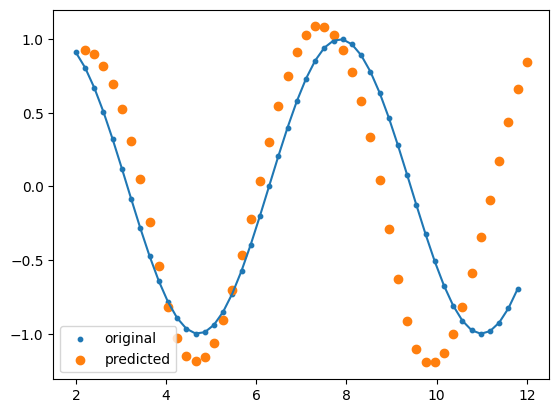

In [7]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

# number of points
num_time_steps = 50
hidden_size = 10
input_size = 1
output_size = 1
lr = 0.01


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, hidden_size)  # stack batch and seq

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev



model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 1, hidden_size)  # [b, layer, mem_size]

for iter in range(6000):
    # randomly generate start point from 0 to 2
    start = np.random.randint(3, size=1)[0]
    # eg. from 0 to 10, create 50 points in between
    time_steps = np.linspace(start, start + 10, num_time_steps)
    data = np.sin(time_steps)
    data = data.reshape(num_time_steps, 1)
    # x: 49 points 0-49; y: 49 points 1-50
    x = torch.tensor(data[:-1]).float().reshape(1, num_time_steps - 1, 1)  # [b, seq_len, fea_len]
    y = torch.tensor(data[1:]).float().reshape(1, num_time_steps - 1, 1)  # [b, seq_len, fea_len]

    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    # print(f"output {output.shape}, y {y.shape}")
    loss = criterion(output, y)
    model.zero_grad()
    # optimizer.zero_grad()
    # both zero_grad() are the same if model.parameters() is feed to the same optimizer
    # only matters if multiple models using same optimizer or multiple optims used for a model
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
       print(f"iteration: {iter}, loss {loss.item()}")

start = np.random.randint(3, size=1)[0]
time_steps = np.linspace(start, start+10, num_time_steps)
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
x = torch.tensor(data[:-1]).float().reshape(1, num_time_steps-1, 1)

preds = []
input_x = x[:, 0, :]  # select first point
for _ in range(x.shape[1]):
    input_x = input_x.reshape(1, 1, 1)  # reshape it for model feeding
    pred, hidden_prev = model(input_x, hidden_prev)
    # print(pred.shape)
    # print(hidden_prev.shape)
    input_x = pred
    preds.append(pred.detach().numpy().ravel()[0])

x = x.data.numpy().ravel()
plt.scatter(time_steps[:-1], x.ravel(), s=10, label='original')
plt.plot(time_steps[:-1], x.ravel())

plt.scatter(time_steps[1:], preds, label='predicted')
plt.legend()
plt.show()

Epoch [1/10], Loss: 321.8011
Epoch [2/10], Loss: 318.5240
Epoch [3/10], Loss: 315.3155
Epoch [4/10], Loss: 312.1620
Epoch [5/10], Loss: 309.0446
Epoch [6/10], Loss: 305.9320
Epoch [7/10], Loss: 302.7831
Epoch [8/10], Loss: 299.5499
Epoch [9/10], Loss: 296.1915
Epoch [10/10], Loss: 292.6880
Average test loss: 4311.3115


ValueError: x and y must have same first dimension, but have shapes (10,) and (1, 1)

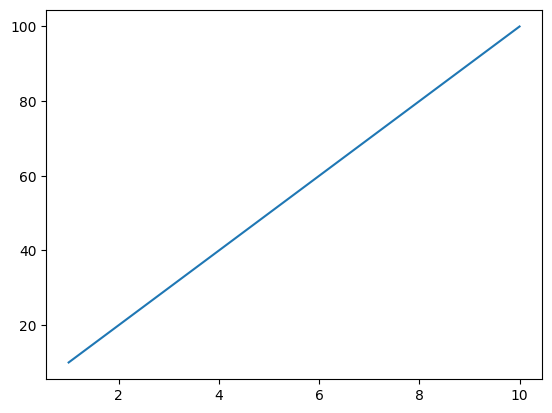